In [1]:
from absl import logging
import tensorflow.compat.v1 as tf

from open_spiel.python import policy
from open_spiel.python import rl_environment
from open_spiel.python.algorithms import exploitability
from open_spiel.python.algorithms import nfsp
from open_spiel.python.pytorch import nfsp as nfsp_pt

class NFSPPolicies(policy.Policy):
  """Joint policy to be evaluated."""

  def __init__(self, env, nfsp_policies, mode):
    game = env.game
    player_ids = [0, 1]
    super(NFSPPolicies, self).__init__(game, player_ids)
    self._policies = nfsp_policies
    self._mode = mode
    self._obs = {"info_state": [None, None], "legal_actions": [None, None]}

  def action_probabilities(self, state, player_id=None):
    cur_player = state.current_player()
    legal_actions = state.legal_actions(cur_player)

    self._obs["current_player"] = cur_player
    self._obs["info_state"][cur_player] = (
        state.information_state_tensor(cur_player))
    self._obs["legal_actions"][cur_player] = legal_actions

    info_state = rl_environment.TimeStep(
        observations=self._obs, rewards=None, discounts=None, step_type=None)

    with self._policies[cur_player].temp_mode_as(self._mode):
      p = self._policies[cur_player].step(info_state, is_evaluation=True).probs
    prob_dict = {action: p[action] for action in legal_actions}
    return prob_dict


def tf_main(game,
            env_config,
            num_train_episodes,
            eval_every,
            hidden_layers_sizes,
            replay_buffer_capacity,
            reservoir_buffer_capacity,
            anticipatory_param):
  env = rl_environment.Environment(game, **env_configs)
  info_state_size = env.observation_spec()["info_state"][0]
  num_actions = env.action_spec()["num_actions"]

  hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
  kwargs = {
      "replay_buffer_capacity": replay_buffer_capacity,
      "epsilon_decay_duration": num_train_episodes,
      "epsilon_start": 0.06,
      "epsilon_end": 0.001,
  }
  expl_list = []
  with tf.Session() as sess:
    # pylint: disable=g-complex-comprehension
    agents = [
        nfsp.NFSP(sess, idx, info_state_size, num_actions, hidden_layers_sizes,
                  reservoir_buffer_capacity, anticipatory_param,
                  **kwargs) for idx in range(num_players)
    ]
    expl_policies_avg = NFSPPolicies(env, agents, nfsp.MODE.average_policy)

    sess.run(tf.global_variables_initializer())
    for ep in range(num_train_episodes):
      if (ep + 1) % eval_every == 0:
        losses = [agent.loss for agent in agents]
        print("Losses: %s" %losses)
        expl = exploitability.exploitability(env.game, expl_policies_avg)
        expl_list.append(expl)
        print("[%s] Exploitability AVG %s" %(ep + 1, expl))
        print("_____________________________________________")

      time_step = env.reset()
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        agent_output = agents[player_id].step(time_step)
        action_list = [agent_output.action]
        time_step = env.step(action_list)

      # Episode is over, step all agents with final info state.
      for agent in agents:
        agent.step(time_step)
  return expl_list
        
def pt_main(game,
            env_config,
            num_train_episodes,
            eval_every,
            hidden_layers_sizes,
            replay_buffer_capacity,
            reservoir_buffer_capacity,
            anticipatory_param):
  env = rl_environment.Environment(game, **env_configs)
  info_state_size = env.observation_spec()["info_state"][0]
  num_actions = env.action_spec()["num_actions"]

  hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
  kwargs = {
      "replay_buffer_capacity": replay_buffer_capacity,
      "epsilon_decay_duration": num_train_episodes,
      "epsilon_start": 0.06,
      "epsilon_end": 0.001,
  }
  expl_list = []
  agents = [
      nfsp_pt.NFSP(idx, info_state_size, num_actions, hidden_layers_sizes,
                   reservoir_buffer_capacity, anticipatory_param,
                   **kwargs) for idx in range(num_players)
  ]
  expl_policies_avg = NFSPPolicies(env, agents, nfsp_pt.MODE.average_policy)  
  for ep in range(num_train_episodes):
    if (ep + 1) % eval_every == 0:
      losses = [agent.loss.item() for agent in agents]
      print("Losses: %s" %losses)
      expl = exploitability.exploitability(env.game, expl_policies_avg)
      expl_list.append(expl)
      print("[%s] Exploitability AVG %s" %(ep + 1, expl))
      print("_____________________________________________")  
    time_step = env.reset()
    while not time_step.last():
      player_id = time_step.observations["current_player"]
      agent_output = agents[player_id].step(time_step)
      action_list = [agent_output.action]
      time_step = env.step(action_list)  
    # Episode is over, step all agents with final info state.
    for agent in agents:
      agent.step(time_step)
  return expl_list

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
game = "kuhn_poker"
num_players = 2
env_configs = {"players": num_players}
num_train_episodes = int(3e6)
eval_every = 10000
hidden_layers_sizes = [128]
replay_buffer_capacity = int(2e5)
reservoir_buffer_capacity = int(2e6)
anticipatory_param = 0.1

In [ ]:
tf_kuhn_result = tf_main(game, 
                         env_configs,
                         num_train_episodes,
                         eval_every,
                         hidden_layers_sizes,
                         replay_buffer_capacity,
                         reservoir_buffer_capacity,
                         anticipatory_param)

Losses: [(0.53785634, 0.9251124), (None, 0.9612581)]
[10000] Exploitability AVG 0.3806265065406539
_____________________________________________
Losses: [(0.36655694, 1.0659907), (0.3947149, 0.7292872)]
[20000] Exploitability AVG 0.25093042241453994
_____________________________________________
Losses: [(0.393549, 0.7483181), (0.24578282, 0.9105486)]
[30000] Exploitability AVG 0.2390693417084421
_____________________________________________
Losses: [(0.57156175, 0.89634085), (0.28940323, 1.1088376)]
[40000] Exploitability AVG 0.1969633608406444
_____________________________________________
Losses: [(0.5530685, 0.77027917), (0.3845034, 0.9829901)]
[50000] Exploitability AVG 0.1952863363167002
_____________________________________________
Losses: [(0.5764897, 1.05086), (0.26840705, 0.9912839)]
[60000] Exploitability AVG 0.1908509819947581
_____________________________________________
Losses: [(0.55077726, 0.9610203), (0.13408442, 0.8307791)]
[70000] Exploitability AVG 0.16578364111899666

[0.3806265065406539,
 0.25093042241453994,
 0.2390693417084421,
 0.1969633608406444,
 0.1952863363167002,
 0.1908509819947581,
 0.16578364111899666,
 0.1516934982537071,
 0.13771536690789724,
 0.13341837902810572,
 0.13644374987004593,
 0.13798249975438104,
 0.14101250876721272,
 0.1441424008015637,
 0.14635210990591047,
 0.14904867960404455,
 0.14844024467962766,
 0.1432817219201606,
 0.1374702476553379,
 0.13646102192037332,
 0.13617992063928874,
 0.13357250781103439,
 0.13009763608049202,
 0.12439814630878687,
 0.12094512628418666,
 0.11838708905427595,
 0.11397190181927891,
 0.11403329146455082,
 0.10923850441120808,
 0.10810779550798735,
 0.10380301031311279,
 0.10169649320455076,
 0.09902836470968551,
 0.10004057069605216,
 0.10122644963548008,
 0.10525184712838637,
 0.10136377450585335,
 0.10103724952952689,
 0.10392499781552858,
 0.1023431129139718,
 0.10803959771600394,
 0.10621570549157452,
 0.10923746880004157,
 0.11087742833249944,
 0.10834048159432741,
 0.10583170394922509

In [3]:
pt_kuhn_result = pt_main(game, 
                         env_configs,
                         num_train_episodes,
                         eval_every,
                         hidden_layers_sizes,
                         replay_buffer_capacity,
                         reservoir_buffer_capacity,
                         anticipatory_param)

/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Losses: [(tensor(0.5617), tensor(1.2384)), (None, tensor(1.0013))]
[10000] Exploitability AVG 0.43360760977233226
_____________________________________________
Losses: [(tensor(0.3933), tensor(1.1907)), (tensor(0.4485), tensor(0.7598))]
[20000] Exploitability AVG 0.24847993754583325
_____________________________________________
Losses: [(tensor(0.4599), tensor(1.1885)), (tensor(0.2461), tensor(1.1361))]
[30000] Exploitability AVG 0.20212825474698204
_____________________________________________
Losses: [(tensor(0.4765), tensor(1.1473)), (tensor(0.3217), tensor(1.0794))]
[40000] Exploitability AVG 0.16857554855165724
_____________________________________________
Losses: [(tensor(0.4865), tensor(1.1216)), (tensor(0.3131), tensor(1.0331))]
[50000] Exploitability AVG 0.15093939352390653
_____________________________________________
Losses: [(tensor(0.3970), tensor(0.8246)), (tensor(0.2245), tensor(0.8587))]
[60000] Exploitability AVG 0.1405615429270749
_____________________________________

[0.43360760977233226,
 0.24847993754583325,
 0.20212825474698204,
 0.16857554855165724,
 0.15093939352390653,
 0.1405615429270749,
 0.1294691247494251,
 0.12353523661221327,
 0.11647317361335996,
 0.1232920439392188,
 0.13573878440059367,
 0.14339186094670014,
 0.14240849260532548,
 0.13899089965857514,
 0.13552169628343108,
 0.1311198467438126,
 0.1281124486926545,
 0.12401562839008803,
 0.12174890183650688,
 0.1240955312275292,
 0.1254166045280308,
 0.1259693811789879,
 0.12834214679245828,
 0.1306657682547336,
 0.13143155825253564,
 0.1313982201346969,
 0.13012119969670558,
 0.12718786715586541,
 0.12445305499534892,
 0.11940041676270272,
 0.11572987157051917,
 0.11187472004484214,
 0.1078544424117018,
 0.10358764818095975,
 0.10104319488782665,
 0.09718208330912342,
 0.0945093902880978,
 0.09164706043036927,
 0.09040716014241568,
 0.08637893756587489,
 0.0836706606604124,
 0.08252897921824368,
 0.07875484089889032,
 0.0784630829623014,
 0.08089463546506201,
 0.07861132029247281,
 0

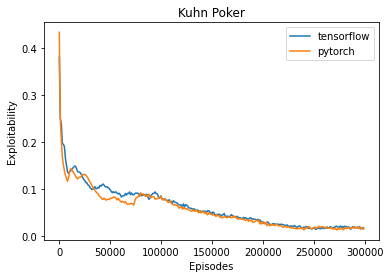

In [11]:
import matplotlib.pyplot as plt

x = [i*1000 for i in range(len(tf_kuhn_result))]

plt.plot(x, tf_kuhn_result, label='tensorflow')
plt.plot(x, pt_kuhn_result, label='pytorch')
plt.title('Kuhn Poker')
plt.xlabel('Episodes')
plt.ylabel('Exploitability')
plt.legend()
plt.show()

In [5]:
game = "leduc_poker"
num_players = 2
env_configs = {"players": num_players}
num_train_episodes = int(3e6)
eval_every = 100000
hidden_layers_sizes = [128]
replay_buffer_capacity = int(2e5)
reservoir_buffer_capacity = int(2e6)
anticipatory_param = 0.1

In [6]:
tf_leduc_result = tf_main(game, 
                          env_configs,
                          num_train_episodes,
                          eval_every,
                          hidden_layers_sizes,
                          replay_buffer_capacity,
                          reservoir_buffer_capacity,
                          anticipatory_param)

Losses: [(0.5390237, 14.245871), (0.44778812, 15.658735)]
[100000] Exploitability AVG 1.6898823214088354
_____________________________________________
Losses: [(0.46877638, 13.020107), (0.46317512, 14.113714)]
[200000] Exploitability AVG 1.420086811832837
_____________________________________________
Losses: [(0.5191153, 12.782812), (0.44340974, 9.09498)]
[300000] Exploitability AVG 1.181871429941547
_____________________________________________
Losses: [(0.42321426, 9.537439), (0.33284122, 9.16)]
[400000] Exploitability AVG 1.0245515925064417
_____________________________________________
Losses: [(0.4591559, 7.893066), (0.5145581, 13.236103)]
[500000] Exploitability AVG 0.8958223060182396
_____________________________________________
Losses: [(0.4845383, 5.753558), (0.38578534, 12.685564)]
[600000] Exploitability AVG 0.8159920007228245
_____________________________________________
Losses: [(0.37469828, 6.724424), (0.39382324, 15.418528)]
[700000] Exploitability AVG 0.7346057720733029


[1.6898823214088354,
 1.420086811832837,
 1.181871429941547,
 1.0245515925064417,
 0.8958223060182396,
 0.8159920007228245,
 0.7346057720733029,
 0.7057984875903107,
 0.6972515890040387,
 0.6737432047433465,
 0.6852156897082571,
 0.6621826836650042,
 0.6766518776527517,
 0.5827228998283466,
 0.5291790984510443,
 0.5022623112379254,
 0.48630643816425995,
 0.4935168184226987,
 0.47340736864293803,
 0.4510645650692823,
 0.4561857999571657,
 0.4317089958795024,
 0.4208609647837446,
 0.421839634060961,
 0.40056422894510424,
 0.411465908371901,
 0.38803892703328446,
 0.367132770241162,
 0.3633606374587205,
 0.35713582160929336]

In [7]:
pt_leduc_result = pt_main(game, 
                          env_configs,
                          num_train_episodes,
                          eval_every,
                          hidden_layers_sizes,
                          replay_buffer_capacity,
                          reservoir_buffer_capacity,
                          anticipatory_param)

Losses: [(tensor(0.7167), tensor(10.2624)), (tensor(0.6678), tensor(24.5570))]
[100000] Exploitability AVG 1.7760776446223332
_____________________________________________
Losses: [(tensor(0.6730), tensor(14.0845)), (tensor(0.6229), tensor(16.1690))]
[200000] Exploitability AVG 1.4667133317281158
_____________________________________________
Losses: [(tensor(0.6050), tensor(15.1587)), (tensor(0.5255), tensor(16.4437))]
[300000] Exploitability AVG 1.2494437745597449
_____________________________________________
Losses: [(tensor(0.5169), tensor(9.0873)), (tensor(0.4858), tensor(12.4749))]
[400000] Exploitability AVG 1.120871150332515
_____________________________________________
Losses: [(tensor(0.6774), tensor(8.6445)), (tensor(0.4650), tensor(11.7802))]
[500000] Exploitability AVG 1.1015036650424368
_____________________________________________
Losses: [(tensor(0.4969), tensor(7.8441)), (tensor(0.6199), tensor(11.1916))]
[600000] Exploitability AVG 1.0245672591492947
__________________

[1.7760776446223332,
 1.4667133317281158,
 1.2494437745597449,
 1.120871150332515,
 1.1015036650424368,
 1.0245672591492947,
 0.9445766513183707,
 0.8684752481367197,
 0.8006560040555245,
 0.8018183519995761,
 0.7926676079915461,
 0.7992893814920394,
 0.8035728366445121,
 0.756405194780331,
 0.742653918177091,
 0.6744911938268123,
 0.6481299471024332,
 0.6340046779741395,
 0.6052965706103838,
 0.6071257458704584,
 0.5775614842977357,
 0.5430772967943114,
 0.5485013972001643,
 0.5387629731446001,
 0.5407604559108162,
 0.5217140821286138,
 0.4710156288266728,
 0.4674406844154157,
 0.45240516373248907,
 0.4589802299847634]

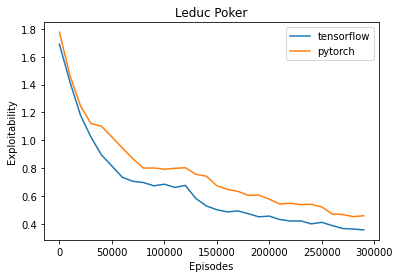

In [14]:
x = [i * 10000 for i in range(len(tf_leduc_result))]

plt.plot(x, tf_leduc_result, label='tensorflow')
plt.plot(x, pt_leduc_result, label='pytorch')
plt.title('Leduc Poker')
plt.xlabel('Episodes')
plt.ylabel('Exploitability')
plt.legend()
plt.show()